### Integration of SVM and MVO 
3 factor, 3 turnover, premium of 10% experiments

This notebook only contains exact solves

In [1]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB
pth = ''
import sys
import math
import time

from python.packages import *
from python.svm_mvo import *
from python.svm import *
from python.analysis_tools import *
from python.dual_svm_mvo import *

%matplotlib inline
## Import Forecasts
forecasts = pd.read_pickle(pth +'cache/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'cache/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'cache/WRDS_ASOF.pkl')
## Import monthly prices
prices = pd.read_pickle(pth + 'cache/PRICES.pkl')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03
Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-03


In [2]:
prev_mth = rets.index[0]
start_mth = prev_mth + pd.DateOffset(months=1)

In [3]:
#rank transform wrds
dfs = []
for name, df_group in wrds_svm.groupby(['MonthStart']):
    ranked_df = df_group.loc[:,'srcq':'Vol'].rank(axis = 0)/(len(df_group)+1)
    standardized_df = (ranked_df - ranked_df.mean(axis = 0))/ranked_df.std(axis = 0)
    standardized_df.drop(columns= ['DIFFYear', 'date', 'DIFFMonth', 'DIFFActualDays', 'DIFFExpectedDays', 'DIFFExpectedDaysCorr'], inplace = True)
    dfs.append(standardized_df)
wrds_standard = pd.concat(dfs, axis = 0, ignore_index= False)

In [4]:
#groupby then rank within groups
flattened_returns = rets.melt(ignore_index=False, var_name='tic').reset_index()
flattened_returns = flattened_returns.rename(columns ={'StartMonth': 'MonthStart'})
flattened_returns.index = pd.MultiIndex.from_frame(flattened_returns[['MonthStart', 'tic']])
flattened_returns.drop(columns = ['MonthStart', 'tic'], inplace=True)
dataset = pd.merge(flattened_returns, wrds_standard, left_index=True, right_index=True, how = 'inner')
dataset.sort_index(inplace=True)

In [22]:
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE

ratio = 0.1 #% of assets

cols = ['Vol', 'ceqq']
idx = pd.IndexSlice
X = dataset.loc[idx[prev_mth,:], cols].values #['Vol', 'ceqq']].values #'srcq':'Vol'].values
y = dataset.loc[idx[prev_mth,:], 'value'].values
y = (y  >= np.percentile(y, 100*(1- ratio))).astype(int)
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

#preprocessing
cov_, mean_ = forecasts[start_mth]
N = len(mean_)

cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])

#get the wharton research data for the valid tickers for the month
#cols =  ['INV3', 'PRO6', 'INV1']
Y = wrds_standard.loc[(start_mth,), cols] # Y matrix in formulation

dpi_setting = 150

In [163]:

ret_constr = -1 #no return constraint
soft_margin = 100 #maximum preference for separation feasibility

name = "final"
card_desc = "Card07"

turnover_descs = ["0_75", "1", "1_25"]
turnovers = [0.75/6, 1.00/6, 1.25/6] #divide by 6!
AssetLim = math.floor(N*ratio)

epsilon = 1 #epsilon hyper-parameter

non_negativity_setting = True #set the hyperplane to have a normal in the non-negative orthant
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
            #SVM Heavy to not heavy
epsilons = [1e-2, 1e-3, 1e-4]
epsilons_desc = {1e-2:"eps negative 2", 1e-3:"eps negative 3", 1e-4:"eps negative 4"}
card_desc_list = {0.1:"Card01", 0.3:"Card03", 0.5:"Card05", 0.7:"Card07", 0.9:"Card09"}


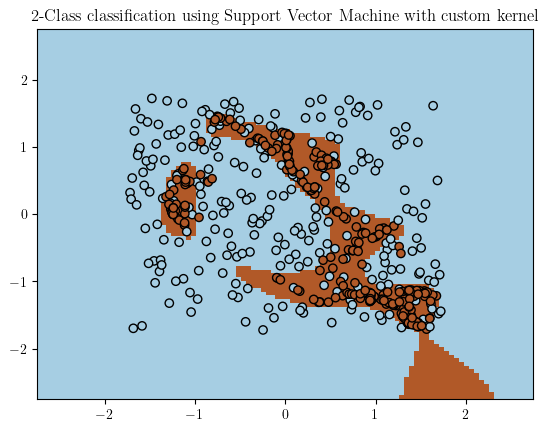

The best parameters are {'sbf__gamma': 0.836251030950374, 'svm__C': 3125.0, 'svm__kernel': 'precomputed'} with a score of 0.84
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 1 rows, 514 columns and 514 nonzeros
Model fingerprint: 0x233113c3
Model has 132355 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-08, 2e+00]
  Bounds range     [3e+03, 3e+03]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.00s
Presolved: 1 rows, 514 columns, 514 nonzeros
Presolved model has 132355 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 197
 AA' NZ     : 1.950e+04
 Factor NZ  : 1.970e+04 (roughly 1 MB of memory)
 Factor Ops : 2.607e+06 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          Dual 

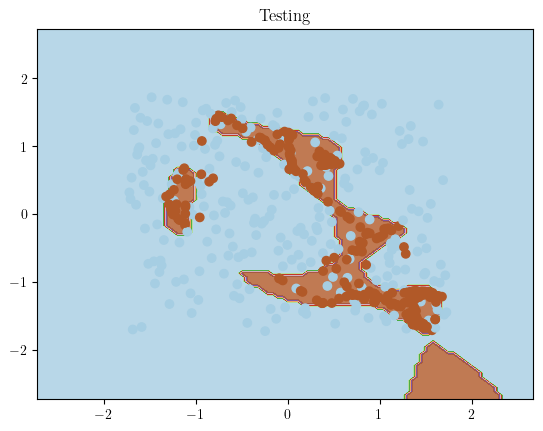

In [164]:
previous_alpha, gamma = compute_best_classifer(X, y, plot = True)

In [165]:

def check_dual_partial_min(instance, alpha_prev):
    """checks for partial min"""

    return np.abs(instance.SVM_.alpha.x - alpha_prev).sum() < 10 ** (-12)


def check_dual_global_convergence(instance, z_param_init=None, x_param_init=None):
    """checks for global convergence"""
    if z_param_init is not None:
        big_x_old = (x_param_init > 1e-4).astype(int)
        big_x_new = (instance.MVO_.x.x > 1e-4).astype(int)
        z_changed = np.abs(big_x_old - big_x_new).sum()/len(z_param_init) > instance.change_threshold
        print(np.abs(big_x_old - big_x_new).sum()/len(z_param_init))
    else:
        z_changed = False

    feasible = instance.MVO_.xi.x.sum() < 10 ** (-9)

    return feasible or z_changed




class DUAL_SVM_MVO_ADM:
    # '''this class models the integrated SVM MVO problem using the ADM solution method'''

    def __init__(self, MVO_, SVM_, IterLim=20, ParamLim=10):
        self.MVO_ = MVO_
        self.SVM_ = SVM_
        self.IterLim = IterLim
        self.ParamLim = ParamLim
        self.x = None
        self.z = None
        self.w = None
        self.b = None
        self.xi_svm = None
        self.xi_mvo = None
        self.track_change = False
        self.change_threshold = 1
    @property
    def describe(self):
        desc = "SVM MVO with Alternating Direction Method"
        shrt = "SVM MVO ADM"
        return desc, shrt

    @property
    def portfolio_risk(self):
        return self.MVO_.x @ self.MVO_.cov @ self.MVO_.x

    @property
    def port_exptd_ret(self):
        return self.MVO_.mean_ret[:, 0] @ self.MVO_.x

    # @property
    # def soft_penalty(self):
    #     n, m = self.SVM_.exogenous.shape
    #     return self.SVM_.soft_penalty

    @property
    def soft_penalty_mvo(self):

        return self.MVO_.soft_penalty

    # @property
    # def svm_margin(self):
    #     return None
    #     #return (1 / 2) * (self.SVM_.alpha @ self.SVM_.alpha)

    @property
    def tics(self):
        return self.MVO_.tics


    def objective_svm(self, delta):
        if delta == 0:
            objective = self.SVM_.svm_objective.getValue()
        else:
            objective = self.SVM_.svm_objective.getValue() + delta*self.SVM_.svm_change.getValue()
        if type(objective) is np.float64:
          return objective
        else:
          return objective[0]

    @property
    def objective_mvo(self):
        objective = self.portfolio_risk.getValue() + self.soft_penalty_mvo.getValue()
        if type(objective) is np.float64:
          return objective
        else:
          return objective[0]

    def initialize_soln(self, set_return=True, constrs=None, svm_constrs=None, warm_starts=None,
                        delta=0, alpha_prev_soln=None, previous_z = None, previous_exogenous = None):
        if svm_constrs is None:
            svm_constrs = []
        if constrs is None:
            constrs = []
        self.MVO_.soft_margin = 0  # on initiliation make sure that the oftmargin is 0
        self.MVO_.set_model(set_return, constrs, warm_starts)  # set up the model
        self.MVO_.optimize()  # find optimal solution

        if self.MVO_.model.status in (3, 4):
            return  # return threshold must be reduced
        self.SVM_.z = self.MVO_.z.x

        self.SVM_.previous_alpha = alpha_prev_soln
        self.SVM_.previous_z = previous_z
        self.SVM_.previous_exogenous = previous_exogenous

        self.SVM_.set_model(svm_constrs, delta)
        self.SVM_.optimize()

    def solve_adm(self, store_data=True, set_return=True, constrs=None, svm_constrs=None, delta=0,
                  alpha_prev_soln=None):
        if svm_constrs is None:
            svm_constrs = []
        if constrs is None:
            constrs = []
        alphas = []
        xs = []
        zs = []
        penalty_hist = []
        if self.ParamLim == 1:
            c = np.geomspace(self.SVM_.soft_margin, self.SVM_.soft_margin, self.ParamLim)
        else:
            c = np.geomspace(1e-5, self.SVM_.soft_margin, self.ParamLim)  # initialized to a number > 0

        self.SVM_.soft_margin, self.MVO_.soft_margin = (c[0], c[0])
        xi_mvo = []
        
        objectives_svm, objectives_mvo = ([], [])
        start = time.time()
        end = time.time()
        z_param_init = self.MVO_.z.x
        x_param_init = self.MVO_.x.x
        for k in range(self.ParamLim):
            self.SVM_.soft_margin, self.MVO_.soft_margin = (c[k], c[k])
            #print(self.SVM_.soft_margin)
            i, converged = (0, False)

            alpha_param_init = self.SVM_.alpha.x

            while (i <= self.IterLim) and (not converged):
                alpha_prev = self.SVM_.alpha.x
                x_prev = self.MVO_.x.x
                z_prev = self.MVO_.z.x
                if store_data:
                    alphas.append(self.SVM_.alpha.x)
                    xs.append(self.MVO_.x.x)
                    zs.append(self.MVO_.z.x)
                    xi_mvo.append(self.MVO_.xi.x)
                    objectives_svm.append(self.objective_svm(delta=1))
                    objectives_mvo.append(self.objective_mvo)
                    penalty_hist.append(self.SVM_.soft_margin)
                #update MVO model
                self.MVO_.decision_boundary= self.SVM_.decision_boundary
                self.MVO_.set_model(set_return, constrs, warm_starts=[x_prev, z_prev])
                self.MVO_.optimize()
                #update SVM model
                self.SVM_.z = self.MVO_.z.x
                self.SVM_.set_model(svm_constrs, delta)
                self.SVM_.optimize()
                i += 1

                if check_dual_partial_min(self, alpha_prev):
                    converged = True
                    #print("partial min convergence")
                    if store_data:
                        alphas.append(self.SVM_.alpha.x)
                        xs.append(self.MVO_.x.x)
                        zs.append(self.MVO_.z.x)
                        xi_mvo.append(self.MVO_.xi.x)

                        objectives_svm.append(self.objective_svm(delta=1))
                        objectives_mvo.append(self.objective_mvo)
                        penalty_hist.append(self.SVM_.soft_margin)
                end = time.time()

            if self.track_change:
                if check_dual_global_convergence(self, z_param_init, x_param_init):
                    print("ADM terminated with C = ", np.mean(self.SVM_.soft_margin))
                    break
            else:
                if check_dual_global_convergence(self):
                    print("ADM terminated with C = ", np.mean(self.SVM_.soft_margin))
                    break
            #mult = get_multiplier(self)
            #self.SVM_.soft_margin, self.MVO_.soft_margin = (self.SVM_.soft_margin * mult, self.MVO_.soft_margin * mult)

        xi_svm = None
        #self.SVM_.soft_margin, self.MVO_.soft_margin = (
        #    c * (2 ** (self.ParamLim-1)), c * (2 ** (self.ParamLim-1)))  # reinitialize C
        return np.array(alphas), np.array(xs), np.array(zs), np.array(xi_mvo), np.array(
            xi_svm), end - start, objectives_svm, objectives_mvo, np.array(penalty_hist)

    def evaluate(self, realized_ret):
        ret = np.dot(self.x.X, realized_ret)
        return ret  # use this to calculate out of sample rets and var

    def get_estimates(self):
        vol_metric = np.sqrt(self.MVO_.portfolio_risk.getValue())[0]
        expt_ret_metric = self.MVO_.port_exptd_ret.getValue()[0]
        return [vol_metric, expt_ret_metric]  # use this for efficient frontiers

    def silence_output(self):
        self.MVO_.model.Params.LogtoConsole = 0
        self.SVM_.model.Params.LogtoConsole = 0

    def get_results(self, export_dir='', fig_size=()):

        lng, shrt = self.describe
        vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
        expt_ret_metric = self.port_exptd_ret.getValue()[0]
        results = pd.DataFrame(data=np.append(self.x.X, [vol_metric, expt_ret_metric]),
                               index=list(self.tics) + ['Volatility', 'Expected Return'], columns=[lng])

        if export_dir != '':
            results.to_csv(export_dir + 'results.csv')

        if fig_size != () and type(fig_size) in [list, tuple]:
            results[:-2].plot.bar(figsize=fig_size)

        return results.transpose()

In [166]:
class MVO:
    # This class models the mean variance sub-problem in the ADM method

    big_m = 100

    # noinspection PyTypeChecker
    def __init__(self, tics, mean_ret, cov, ret_constr, asset_lim,
                 soft_margin=0, decision_boundary = None, asset_lim_lower=0, epsilon=0.001):
        self.tics = tics  # list of tickers
        self.mean_ret = mean_ret
        self.cov = cov
        self.ret_constr = ret_constr
        self.AssetLim = asset_lim
        self.AssetLim_Lower = asset_lim_lower
        n = len(mean_ret)

        self.model = gp.Model(env=e)
        self.x = self.model.addMVar(n)
        self.z = self.model.addMVar(n, vtype=GRB.BINARY)
        self.v = self.model.addMVar(n, lb=np.zeros(n))
        self.q = self.model.addMVar(n)
        self.xi = self.model.addMVar(n, lb=np.zeros(n))
        self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')

        self.decision_boundary = decision_boundary #vector for each asset defining decision boundary

        self.soft_margin = soft_margin

        self.epsilon = epsilon
        self.model.update()

        self.abs = self.model.addMVar(n)

        min_eig = min(np.linalg.eigvals(self.cov)) - 10 ** (-8)
        self.posdef_diag = np.diag(np.ones(n)) * min_eig

    @property
    def portfolio_risk(self):
        return self.x @ self.cov @ self.x

    @property
    def port_exptd_ret(self):
        return self.mean_ret[:, 0] @ self.x

    @property
    def soft_penalty(self):
        n = len(self.mean_ret)
        if np.isscalar(self.soft_margin):
            return (1 / n) * self.soft_margin * (self.xi.sum())
        else:
            return (1 / n) * (self.soft_margin[:, 0] @ self.xi)

    @property
    def portfolio_risk_p(self):
        return portfolio_risk_posdef(self)

    def print_var_info(self, names=None):

        # dictionary of variables and their names
        if names is None:
            names = {}
        for key in names.keys():
            print(key, names[key])
        print("x", self.x.X)
        print("z", self.z.X)
        print("")

    def set_model(self, set_return=True, constrs=None, warm_starts=None):

        # parameter definitions
        if constrs is None:
            constrs = []
        if warm_starts is None:
            warm_starts = []

        if warm_starts:  # start is a list
            self.x.start = warm_starts[0]
            self.z.start = warm_starts[1]
        self.model.remove(self.model.getConstrs())
        n = len(self.mean_ret)

        # objective function components
        if set_return:
            # remove constraints and reset the return constraints
            self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
        if constrs:
            for con in constrs:
                self.model.addConstr(con, 'target')

        self.model.update()
        self.model.addConstr(self.x.sum() == 1, 'budget')

        self.model.addConstr(self.z.sum() <= self.AssetLim, 'Cardinality')
        self.model.addConstr(self.z.sum() >= self.AssetLim_Lower, 'Cardinality')

        self.model.addConstr(self.x <= self.z, "z force x")
        self.model.setObjective((100/9)*self.portfolio_risk + self.soft_penalty, GRB.MINIMIZE)

        # the SVM info must be uninitialized on the first run
        if self.decision_boundary is not None:
            for i in range(n):
                a = self.decision_boundary[i]
                # self.model.addConstr((-1) * self.epsilon + self.xi[i] + big_m * self.z[i] >= a, "svm1")
                # self.model.addConstr(-1 * big_m * (1 - self.z[i]) + 1 * self.epsilon - self.xi[i] - a <= 0, "svm2")
                self.model.addConstr(2*a[0]*self.z[i] >= a[0] + self.epsilon - self.xi[i], 'svm'+str(i))

    def optimize(self, cbb=None):

        if cbb not in [None]:
            self.model._cur_obj = float('inf')
            self.model._time = time.time()
            self.model.optimize(callback=cbb)
        else:
            self.model.optimize()
        self.model.write('portfolio_selection_optimization.lp')

    def evaluate(self, realized_ret):

        ret = np.dot(self.x.X, realized_ret)
        return ret  # use this to calculate out of sample rets and var

    def get_estimates(self):

        vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
        expt_ret_metric = self.port_exptd_ret.getValue()[0]
        return [vol_metric, expt_ret_metric]  # use this for efficient frontiers

    def define_turnover(self, x0, prices, limit, cost):
        for v, absv, curr in zip(self.x.tolist(), self.abs.tolist(), x0.tolist()):
            self.model.addConstr(absv >= v - curr, "turnover constraint1")
            self.model.addConstr(absv >= curr - v, "turnover constraint2")
        q = cost * 1 / np.maximum(1, prices)
        self.model.addConstr(self.abs @ q <= limit, "turnover constraint3")


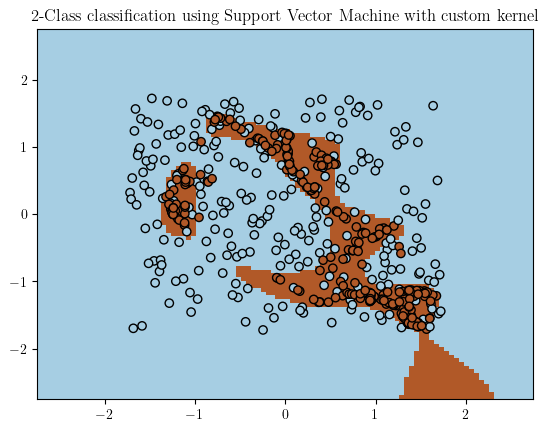

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 1 rows, 514 columns and 514 nonzeros
Model fingerprint: 0x233113c3
Model has 132355 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  QObjective range [2e-08, 2e+00]
  Bounds range     [3e+03, 3e+03]
  RHS range        [0e+00, 0e+00]
Presolve time: 0.02s
Presolved: 1 rows, 514 columns, 514 nonzeros
Presolved model has 132355 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 197
 AA' NZ     : 1.950e+04
 Factor NZ  : 1.970e+04 (roughly 1 MB of memory)
 Factor Ops : 2.607e+06 (less than 1 second per iteration)
 Threads    : 14

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.21054933e+06  6.47678126e+08  1.08e+05 4.48e-01  2.31e+06     0s
   1  -1.51

In [167]:
previous_alpha, gamma = compute_best_classifer(X, y, plot=False)
MVO_ = MVO(tics, mean, cov, ret_constr, AssetLim, epsilon=epsilon, soft_margin = soft_margin)
kernel = CustomRBFKernel(gamma = gamma)
SVM_ = DualSVM(Y.values , kernel =kernel, epsilon = epsilon, soft_margin = soft_margin)
SVM_.previous_alpha = previous_alpha
SVM_.previous_exogenous = X
SVM_.previous_z = y
MVO_.model.params.MIPGap = 0.05
MVO_.model.params.timelimit = 10
SVM_.model.params.timelimit = 60
MVO_.model.params.OutputFlag = 0
SVM_.model.params.OutputFlag = 0

SVM_MVO_Fast = DUAL_SVM_MVO_ADM(MVO_, SVM_, IterLim = 3, ParamLim = 5)


SVM_MVO_Fast.track_change = True #determine global convergence if z has change by more than 20%
SVM_MVO_Fast.change_threshold = 0.2 #if z has changed by twenty percent or more then we have achieved convergence

SVM_MVO_Fast.silence_output()
SVM_MVO_Fast.initialize_soln(delta=1, alpha_prev_soln=previous_alpha, previous_z = y, previous_exogenous = X)
print("Initialization successful")
ws , xs, zs , xi_mvo, xi_svm, dt, objs_svm, objs_mvo, penalty_hist = SVM_MVO_Fast.solve_adm()
end = time.time()

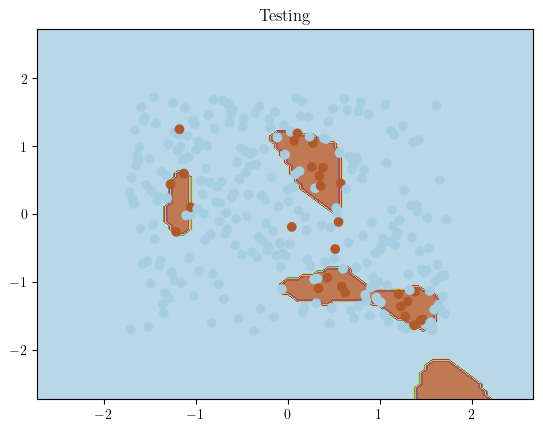

In [168]:
plotSVC('Testing', Y.values, MVO_.z.x, SVM_)

Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 290 rows, 1716 columns and 1716 nonzeros
Model fingerprint: 0xab22ff25
Model has 41041 quadratic objective terms
Variable types: 1430 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-06, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Found heuristic solution: objective 0.1046238
Presolve removed 2 rows and 1144 columns
Presolve time: 0.00s
Presolved: 288 rows, 572 columns, 1144 nonzeros
Presolved model has 41041 quadratic objective terms
Variable types: 286 continuous, 286 integer (286 binary)

Root relaxation: objective 7.190376e-03, 184 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

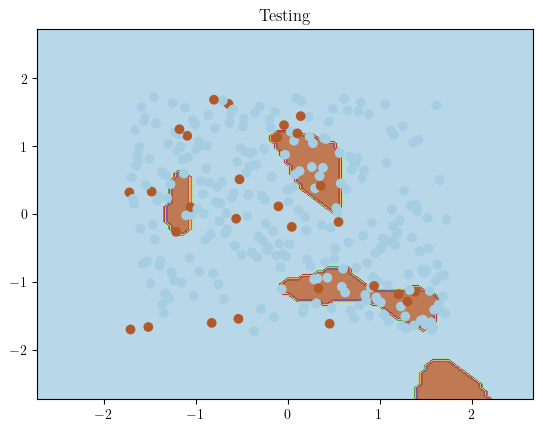

In [169]:
MVO_2 = MVO(tics, mean, cov, ret_constr, AssetLim, epsilon=epsilon)
MVO_2.model.params.MIPGap = 0.05
MVO_2.set_model()
MVO_2.optimize()
plotSVC('Testing', Y.values, MVO_2.z.x, SVM_)

In [161]:
objs_mvo

[0.0006644862770021948,
 0.0006754400954061896,
 0.0006814037955619703,
 0.0011994651870728147,
 0.0011616627230313843,
 0.001160289179465868,
 0.0011592982796924836,
 0.016350007694375727,
 0.009744626941051372,
 0.16821040439343526,
 5.294933285756414,
 5.294933285756414,
 167.4161456618386,
 167.4161456618386]

In [162]:
objs_svm

[2362.029835327354,
 492.4733955553412,
 492.4733955553412,
 492.4733955553412,
 523.0906935732698,
 528.6528678224533,
 528.6528678224533,
 528.6528678224533,
 499.4058916910162,
 499.4058916910162,
 499.4058916910162,
 499.4058916910162,
 499.4058916910162,
 499.4058916910162]

In [81]:
0.0006644/12940

5.134466769706337e-08